# Introduction to JAX ♥ 👨‍💻 🚀
<br>

![](https://user-images.githubusercontent.com/41967348/140406260-96e6a1fe-9285-4328-8343-25895f84480c.png)

<br>

**Author**: [Sayan Nath](https://twitter.com/sayannath2350)

## Imports

In [2]:
import numpy as np
import jax.numpy as jnp

# Import transform functions
from jax import grad, jit, vmap, pmap

from jax import lax # lax is a low level api of JAX
from jax import make_jaxpr
from jax import random 
from jax import device_put

import matplotlib.pyplot as plt

## `jit()` 

- `.jit()` compiles the functions and cache them.

In [3]:
# Util function to visualise the data-points
def visualize_fn(fn, l=-10, r=10, n=1000):
    x = np.linspace(l, r, num=n)
    y = fn(x)
    plt.plot(x, y); plt.show()

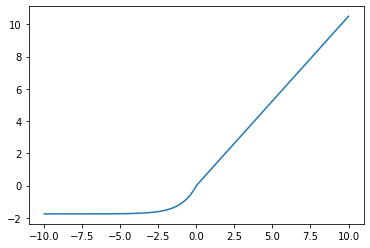

Non-jit version
The slowest run took 232.50 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 2.09 ms per loop
jit version
The slowest run took 728.59 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 182 µs per loop


In [4]:
# Define a selu activation function
def selu(x, alpha=1.67, beta=1.05):
    """Reference: https://www.tensorflow.org/api_docs/python/tf/keras/activations/selu"""
    return beta * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

selu_jit = jit(selu) # Let's compile the function in jit

# Visualize SELU
visualize_fn(selu)

SEEDS=42

key = random.PRNGKey(SEEDS)
data = random.normal(key, (1000000,))

## Stress test
print('Non-jit version')
%timeit selu(data).block_until_ready()
print('jit version')
%timeit selu_jit(data).block_until_ready()

## `grad()` 

grad => differentiation

Types of differentiation
* manual
* symbolic
* numeric
* automatic (Fav of all)

In [5]:
# First Example

## Define the function
def custom_func(x):
    return jnp.sum(x**4) # x**4 = x^4

y = jnp.arange(2.)
print(y)

# Compute the differentiation (automatic)
grad_value = grad(custom_func) # Differentiation of x^4 is 4x^3. The custom_func returns 4*0^3 and 4*1^3 i.e 0 and 4

# Evaluate the function
print(grad_value(y))

[0. 1.]
[0. 4.]


In [6]:
# Second Example

def finite_diff(f, x):
    eps = 1e-3

    return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)
                    for v in jnp.eye(len(x))])
    
print(finite_diff(custom_func, y))

[0.        4.0000377]


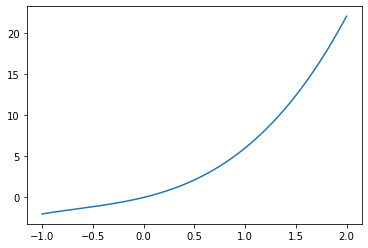

6.0
10.0
10.0
6.0


In [7]:
# Third Example

## Input
x = 1.

# Lambda function
func = lambda x: x**3 + 2*x**2 + 3*x  # f(xy) = x^3 + 2x^2 + 3x
visualize_fn(func, l=-1, r=2, n=1000) # Visualising the function

# First order differentiation
dfdx = grad(func) #If we want to find derrivate with respect to another variable suppose y then we need to do like this grad(func, argnums=(1)) as it takes 0 as default. 

# Second order differentiation
d2fdx = grad(dfdx) # d2fdx = grad(grad(func))

# Third order differentiation
d3fdx = grad(d2fdx) # d3fdx = grad(grad(grad(func))) 

print(func(x))
print(dfdx(x))
print(d2fdx(x))
print(d3fdx(x))

In [8]:
# Fourth Example

from jax import jacfwd, jacrev

f = lambda x, y: x**2 + y**2  # Paraboloid 

# df/dx = 2x
# df/dy = 2y
# J = [df/dx, df/dy]

# d2f/dx = 2
# d2f/dy = 2
# d2f/dxdy = 0
# d2f/dydx = 0
# H = [[d2f/dx, d2f/dxdy], [d2f/dydx, d2f/dy]]

def hessian(f):
    return jit(jacfwd(jacrev(f, argnums=(0, 1)), argnums =(0, 1)))

print(f'Jacobian = {jacrev(f, argnums=(0, 1))(1., 1.)}')
print(f'Full Hessian = {hessian(f)(1., 1.)}')

Jacobian = (DeviceArray(2., dtype=float32), DeviceArray(2., dtype=float32))
Full Hessian = ((DeviceArray(2., dtype=float32), DeviceArray(0., dtype=float32)), (DeviceArray(0., dtype=float32), DeviceArray(2., dtype=float32)))


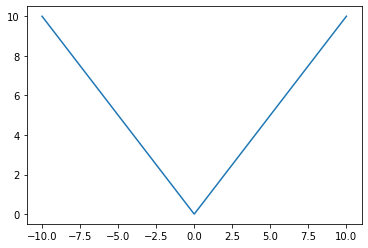

1 1
1.0


In [9]:
# Edge case |x|

f = lambda x: abs(x)
visualize_fn(f)

print(f(-1), f(1))

dfdx = grad(f)
print(dfdx(0.)) 

## `vmap()` 

* Write your functions as if you were dealing with a single datapoint!

In [10]:
W = random.normal(key, (150, 100))  # e.g. weights of a linear NN layer
batched_x = random.normal(key, (10, 100))  # e.g. a batch of 10 flattened images

print(W.shape)
print(batched_x.shape)

(150, 100)
(10, 100)


In [11]:
def apply_matrix(x):
    return jnp.dot(W, x)  # (150, 100) * (100, 1) -> (150, 1)

def naively_batched_apply_matrix(batched_x):
    return jnp.stack([apply_matrix(x) for x in batched_x])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
The slowest run took 38.79 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 5.21 ms per loop


In [12]:
@jit
def batched_apply_matrix(batched_x):
    return jnp.dot(batched_x, W.T)  # (10, 100) * (100, 150) -> (10, 150)

print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()

@jit  # Note: we can arbitrarily compose JAX transforms! Here jit + vmap.
def vmap_batched_apply_matrix(batched_x):
    return vmap(apply_matrix)(batched_x)

# Task: modify apply_matrix to have 2 inputs and use in_axes arg

print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Manually batched
The slowest run took 14520.67 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 106 µs per loop
Auto-vectorized with vmap
The slowest run took 490.78 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 143 µs per loop


## Thank You